**Table of contents**<a id='toc0_'></a>    
- [Initial Tests](#toc1_)    
- [Using minimize from scipy.optimize](#toc2_)    
- [Using PyTorch](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Initial Tests](#toc0_)

In [90]:
from optic.models.devices import mzm, pm
from optic.utils import parameters
from scipy.signal import find_peaks, welch
import numpy as np
import matplotlib.pyplot as plt
import os

π = np.pi

SpS = 64            # Amostras por símbolo
Rs  = 10e9          # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

t = np.arange(0, SpS*1000)*Ta

Vπ = 2
P = 1
n_peaks = 11


In [91]:
def ddmzm(Ai, u1, u2, Vb1, Vb2, Vπ):
    return 0.5 * Ai * (pm(1, u1 + Vb1, Vπ) + pm(1, u2 + Vb2, Vπ))

In [92]:
def fb_generator(V1, V2, Phase1, Phase2, Vb1, Vb2):
    '''
    par1 = parameters()
    par1.Vpi = Vπ
    par1.Vb = Vb1

    par2 = parameters()
    par2.Vpi = Vπ
    par2.Vb = Vb2

    sigTxo_ = P
    sigTxo_ = mzm(sigTxo_, V1 * np.cos(2 * π * Rs * t + Phase1), par1)
    sigTxo_ =  pm(sigTxo_, V3 * np.cos(2 * π * Rs * t + Phase3), Vπ)
    sigTxo_ = mzm(sigTxo_, V2 * np.cos(2 * π * Rs * t + Phase2), par2)
    '''

    u1 = V1 * np.cos(2 * π * Rs * t + Phase1)
    u2 = V2 * np.cos(2 * π * Rs * t + Phase2)
    fb = ddmzm(P, u1, u2, Vb1, Vb2, Vπ)

    return fb

In [125]:
def get_psd_ByFFT(signal, Fa, NFFT):
    
    fft_result = np.fft.fftshift(np.fft.fft(signal, NFFT))
    power_spectrum = np.abs(fft_result)**2
    psd = power_spectrum / (NFFT*Fa)
    freqs = np.fft.fftshift(np.fft.fftfreq(NFFT, 1 / Fa))
    
    return psd, freqs

In [126]:
def get_indx_peaks(log_Pxx, n_peaks):
    indx = find_peaks(log_Pxx, height=(-350, 0))[0]
    discard = (indx.size - n_peaks)
    indx = indx[int(np.floor(discard/2)): -int(np.ceil(discard/2))]
    return indx

In [131]:
#from numpy.fft import fftshift
def plot_fb(sigTxo_, n_peaks):
    # plot frequency combs
    
    plt.figure(figsize=(10,5));
    
    Pxx, freqs = get_psd_ByFFT(sigTxo_, Fa, 8*1024)
    log_Pxx = 10*np.log10(Pxx)
    
    plt.plot(freqs, log_Pxx, "-",label = 'Espectro do sinal óptico - FFT')

    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    plt.plot(freqs[indx], log_Pxx[indx], 'o')
    plt.legend(loc='lower right')
    plt.xticks(np.arange(-20*Rs,20*Rs+1,5*Rs), np.arange(-20, 20+1, 5))
    plt.xlim(-20*Rs,20*Rs);
    plt.xlabel("Frequência (GHz) - Normalized to symbol rate");
    #plt.ylim(-150,-80);
    plt.grid()
    
    mean = np.mean(log_Pxx[indx])
    var = np.var(log_Pxx[indx]) 
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*mean, "--",label = "peaks mean")
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")
    
    print("Média: %.2f dB" %mean)
    print("Desvio Padrão: %.2f dB" %np.sqrt(var))
    print("Variância: %.2f"%var)
    print("Distância máximo-mínimo: %.2f dB" %(np.max(log_Pxx[indx]) - np.min(log_Pxx[indx])))
    

Média: -99.75 dB
Desvio Padrão: 7.12 dB
Variância: 50.75
Distância máximo-mínimo: 19.06 dB


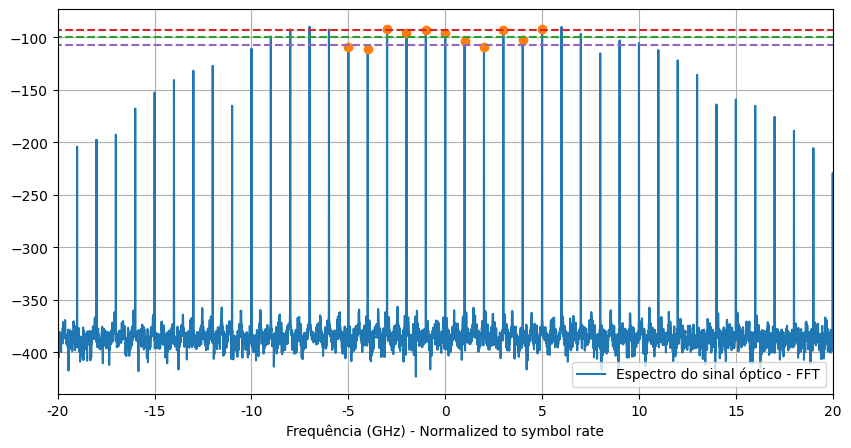

In [139]:
fb = fb_generator(5,5,1,2,1,2)
plot_fb(fb, n_peaks)

In [8]:
import ipywidgets as widgets

def plot_frequencyComb(V1, V2,Phase1, Phase2, Vb1, Vb2):

    plt.figure(figsize=(10,5));

    fb = fb_generator(V1, V2,Phase1, Phase2, Vb1, Vb2)
    log_Pxx, freqs = get_psd_ByFFT(fb, Fa, 16*1024)
    indx = get_indx_peaks(log_Pxx, n_peaks)

    plt.plot(freqs, log_Pxx, label = 'Espectro do sinal óptico')
    plt.plot(freqs[indx], log_Pxx[indx], 'o')
    plt.legend(loc='lower right')
    plt.xlabel("Frequência (GHz) - Normalized to symbol rate");

    plt.xticks(np.arange(-20*Rs,20*Rs+1,5*Rs), np.arange(-20, 20+1, 5))
    plt.xlim(-20*Rs,20*Rs)
    #plt.ylim(-150,-80)
    plt.grid()


V_min = 0.0
V_max = 5.0
Phase_min = 0.0
Phase_max = 2*π
Vb_min = 0.0
Vb_max = 4*Vπ

V1 = widgets.FloatSlider(value=1, min=V_min, max=V_max,step = 0.001, description = 'V1')
V2 = widgets.FloatSlider(value=1, min=V_min, max=V_max,step = 0.001, description = 'V2')
Phase1 = widgets.FloatSlider(value=0, min=Phase_min, max=Phase_max,step = 0.001, description = 'Phase1')
Phase2 = widgets.FloatSlider(value=0, min=Phase_min, max=Phase_max,step = 0.001, description = 'Phase2')
Vb1 = widgets.FloatSlider(value=0, min=Vb_min, max=Vb_max,step = 0.001, description = 'Vb1')
Vb2 = widgets.FloatSlider(value=0, min=Vb_min, max=Vb_max,step = 0.001, description = 'Vb2')


ui1 = widgets.HBox([V1, V2])
ui2 = widgets.HBox([Phase1, Phase2])
ui3 = widgets.HBox([Vb1, Vb2])

out1 = widgets.interactive_output(plot_frequencyComb, {'V1': V1, 'V2': V2,'Phase1':Phase1, 'Phase2':Phase2, 'Vb1': Vb1, 'Vb2': Vb2})
display(ui1, ui2,ui3,out1)

Output()

In [9]:
def plot_sig_and_fb(sig):

    fig, ax = plt.subplots(2,2,figsize = (20,10));
    ax[0,0].plot(t[:SpS*4]*1e9, sig[:SpS*4].real);
    ax[0,1].plot(t[:SpS*4]*1e9, sig[:SpS*4].imag);
    ax[1,0].plot(t[:SpS*4]*1e9, abs(sig[:SpS*4])**2);
    Pxx, freqs = ax[1,1].psd(sig, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')

    #(freqs, Pxx) =  welch(sig, Fa, nperseg=64*1024)
    log_Pxx = 10*np.log10(Pxx)
    #ax[1,1].plot(freqs, log_Pxx)
    
    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    ax[1,1].plot(freqs[indx], log_Pxx[indx], 'o')
    ax[1,1].legend(loc='lower right');
    #ax[1,1].xlim(-16*Rs,16*Rs);
    #ax[1,1].ylim(-100,-80);
    
    mean = np.mean(log_Pxx[indx])
    var = np.var(log_Pxx[indx])
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*mean, "--",label = "peaks mean")
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")
    
    print("Média: %.2f dB" %mean)
    print("Desvio Padrão: %.2f dB" %np.sqrt(var))
    print("Variância: %.2f"%var)
    print("Distância máximo-mínimo: %.2f dB" %(np.max(log_Pxx[indx]) - np.min(log_Pxx[indx])))
    
    ax[0,0].grid()
    ax[0,1].grid()
    ax[1,0].grid()
    #ax[1,1].grid()


Média: -94.73 dB
Desvio Padrão: 8.60 dB
Variância: 73.99
Distância máximo-mínimo: 23.89 dB


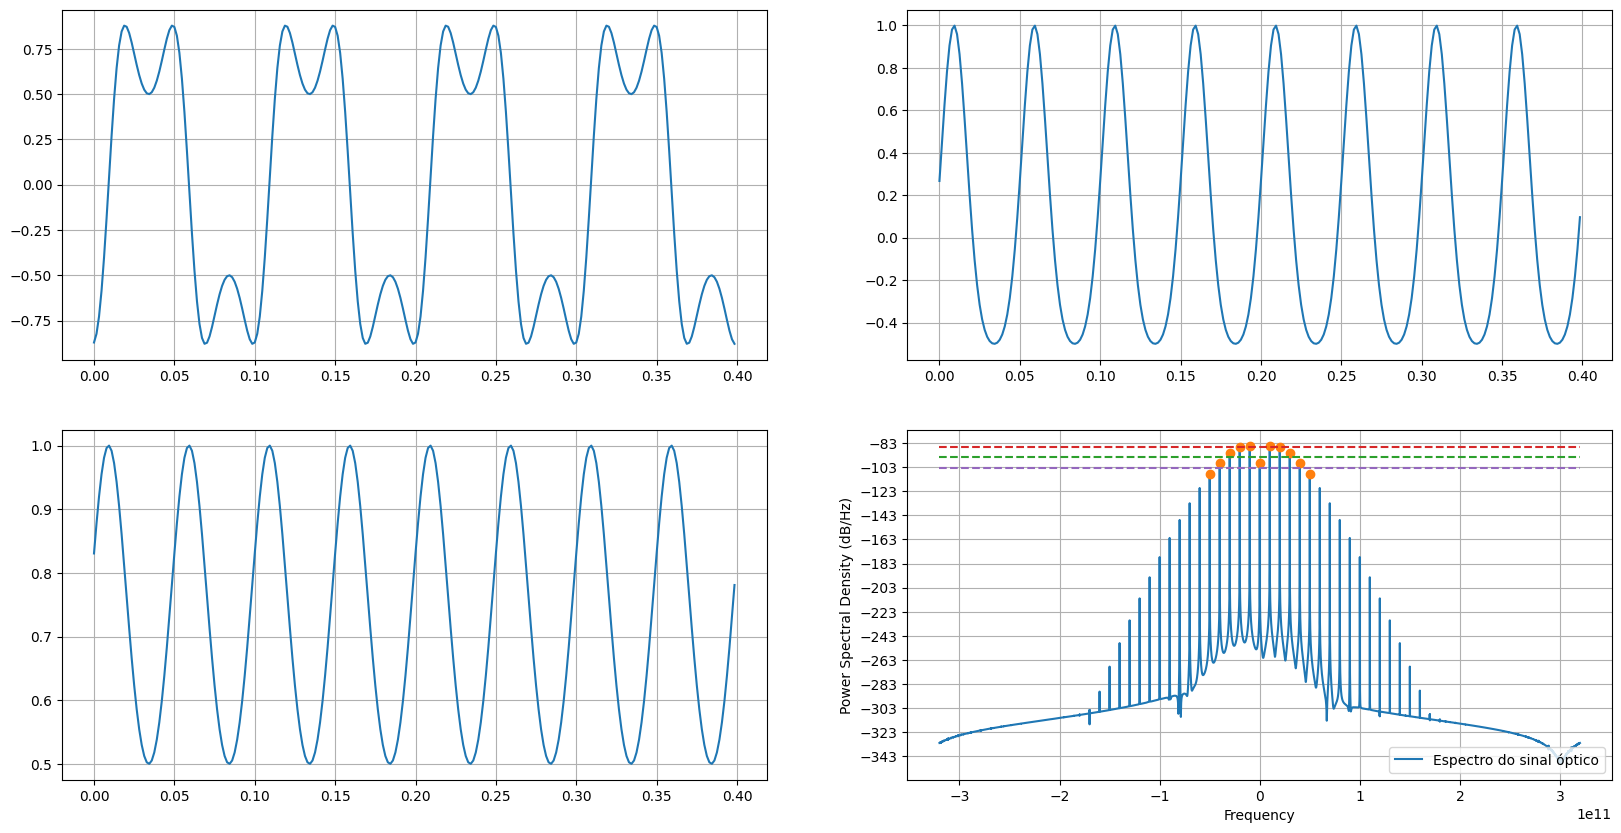

In [10]:
initial_guess = [1, 2,1,1,1,1]
sig = fb_generator(*initial_guess)
plot_sig_and_fb(sig)

# <a id='toc2_'></a>[Using minimize from scipy.optimize](#toc0_)

In [11]:
from scipy.optimize import minimize

# Função objetivo a ser minimizada
def objective_function(params):
    
    sigTxo_ = fb_generator(*params)
    
    # Calcular a intensidade dos picos e a função objetivo
    #fig = plt.figure()
    #fig.set_visible(False)
    Pxx, freqs = plt.psd(sigTxo_, Fs=Fa, NFFT=16 * 1024, sides='twosided')
    #plt.close()
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    var = np.var(log_Pxx[indx])
    target_var = 0
    
    # Objetivo: planificar os picos
    return (var - target_var)**2
 

Configurações otimizadas:
V1: 4.08 V
V2: 1.93 V
Phase1: 3.44 rad
Phase2: 3.35 rad
Vb1: 1.93 V
Vb2: 1.86 V


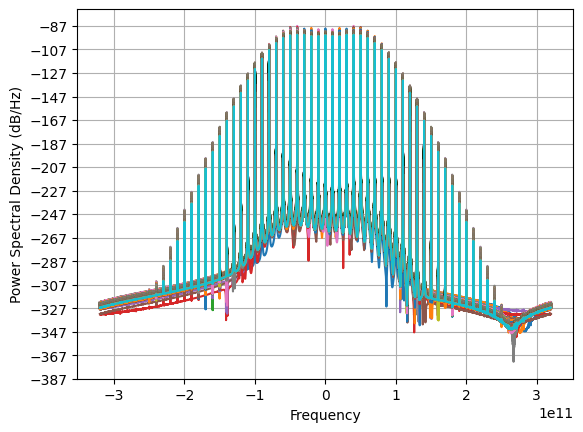

In [22]:
# Chute inicial para as configurações dos moduladores (amplitude e fase)
initial_guess = [3, 2, 2, 2, 3, 2]

V_min = 0
V_max = 5
Phase_min = 0
Phase_max = 2*π
Vb_min = 0
Vb_max = 4*Vπ

bounds = [(V_min,V_max),(V_min,V_max),(Phase_min, Phase_max),(Phase_min, Phase_max),(Vb_min,Vb_max),(Vb_min,Vb_max)]

# Realizar a otimização
method = ["Nelder-Mead", "L-BFGS-B", "TNC", "SLSQP", "Powell", "trust-constr", "COBYLA"]
result = minimize(objective_function, initial_guess, method=method[6],bounds = bounds)
optimized_params = result.x

V1, Phase1,  Vb1, V2, Phase2, Vb2 = optimized_params

# Exibir as configurações otimizadas
print("Configurações otimizadas:")
print(f"V1: {V1:.2f} V")
print(f"V2: {V2:.2f} V")
print(f"Phase1: {Phase1:.2f} rad")
print(f"Phase2: {Phase2:.2f} rad")
print(f"Vb1: {Vb1:.2f} V")
print(f"Vb2: {Vb2:.2f} V")

sigTxo_ = fb_generator(*optimized_params)

Média: -95.04 dB
Desvio Padrão: 0.50 dB
Variância: 0.25
Distância máximo-mínimo: 1.27 dB


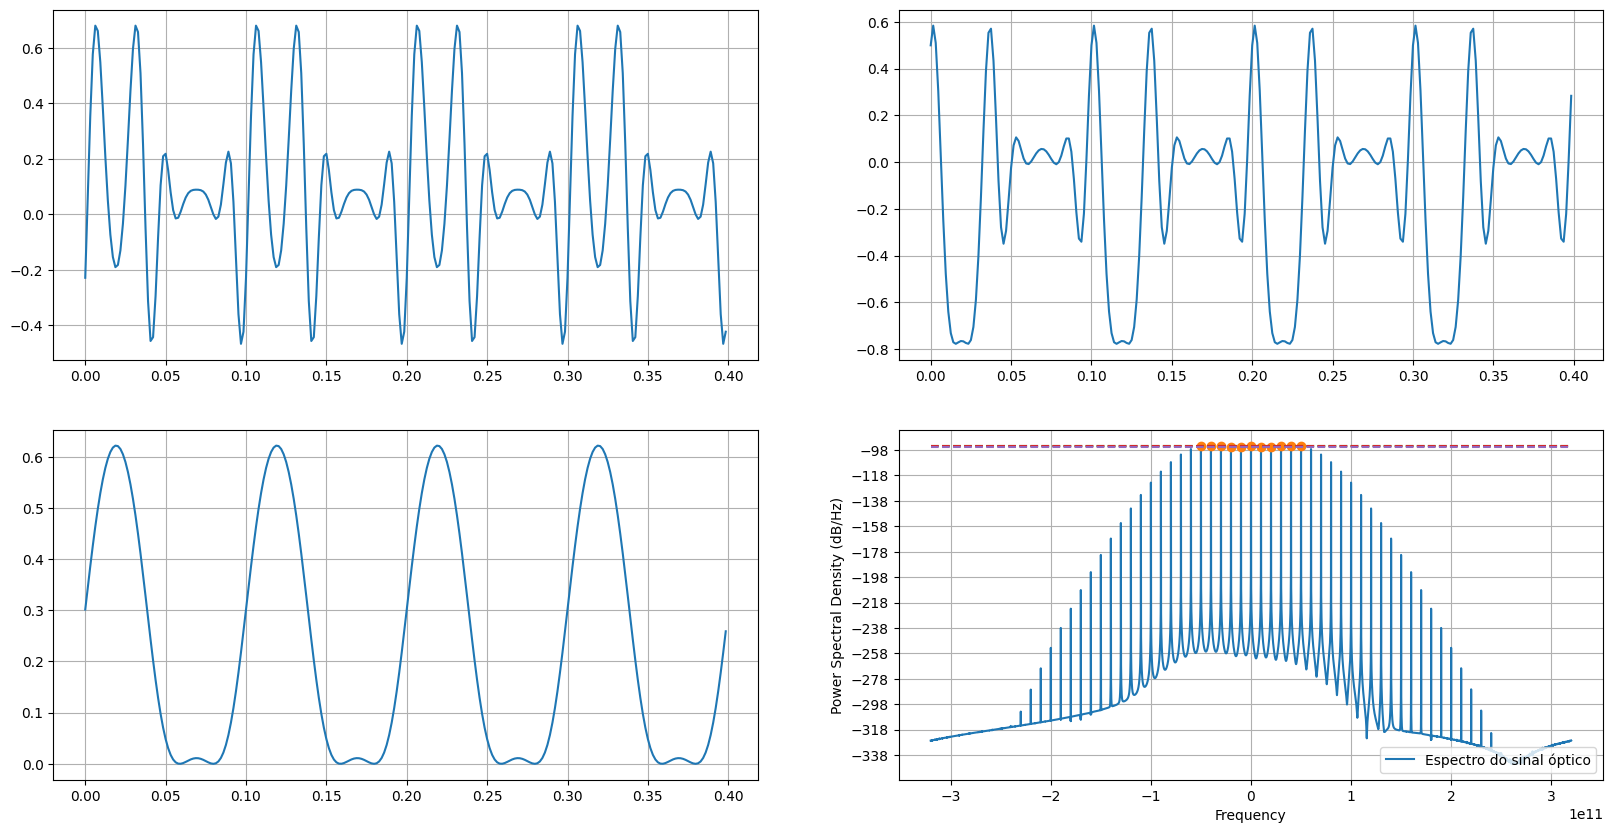

In [23]:
plot_sig_and_fb(sigTxo_)

# <a id='toc3_'></a>[Using PyTorch](#toc0_)

In [24]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand
#import gc

In [25]:
def fb_peaks(V1, V2, Phase1, Phase2, Vb1, Vb2):
    
    fb = fb_generator(V1, V2, Phase1, Phase2, Vb1, Vb2)
    log_Pxx, freqs = get_psd(fb, Fa, 16*1024)
    indx = get_fb_indx_peaks(log_Pxx, freqs, n_peaks, Rs)

    return log_Pxx[indx]

In [26]:
# Define your neural network architecture
class FrequencyCombNet(nn.Module):
    def __init__(self):
        super(FrequencyCombNet, self).__init__()
        self.layers = nn.Sequential(
                    nn.Linear(5, 128),
                    nn.ReLU(),
                    nn.Linear(128, 256),
                    nn.ReLU(),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, 11))

    def forward(self, x):
        return self.layers(x[:, :11])

In [27]:

# Define your custom dataset
class FrequencyCombDataset(Dataset):
    def __init__(self, myfunction, nsamples, bounds):
        self.nsamples = nsamples
        self.bounds = bounds
        self.samples = [[urand.Uniform(low, high).sample().item() for low, high in bounds] for _ in range(nsamples)]
        #self.data = [(torch.tensor(sample, dtype=torch.float32), self.max_abs_scaling(torch.tensor(myfunction(*sample), dtype=torch.float32))) for sample in self.samples] # perhaps list comprehension is faster than for loop
        
        self.data = []
        for sample in self.samples:
            input_tensor = torch.tensor(sample, dtype=torch.float32)
            output_tensor = torch.tensor(myfunction(*sample), dtype=torch.float32)
            output_tensor = self.max_abs_scaling(output_tensor)
            self.data.append((input_tensor, output_tensor))
        

    def __len__(self):
        return len(self.data)
    
    def data_size(self):
        total_size_in_bytes = sum(data.nelement() * data.element_size() + target.nelement() * target.element_size() for data, target in self.data)
        total_size_in_kilobytes = total_size_in_bytes / 1024
        return total_size_in_kilobytes
    
    def max_abs_scaling(self, tensor):
        return tensor / torch.max(torch.abs(tensor)) + 1
    '''
    def unit_vector_normalize(self, tensor):
        return tensor / torch.norm(tensor)
    '''
    def __getitem__(self, idx):
        return self.data[idx]

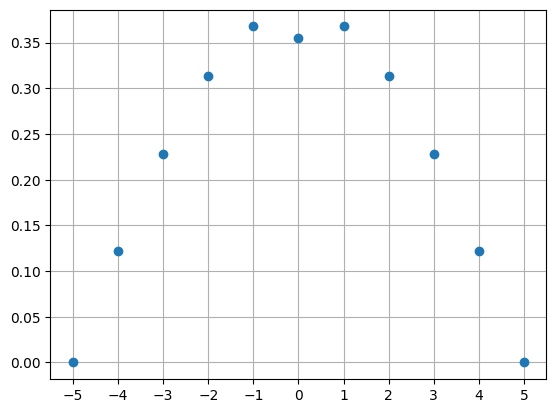

In [28]:

params = [1, 1, 1, 1, 1, 1]

n_peaks = 11
peaks = fb_peaks(*params)

#  The normalization methods max_abs_scaling and unit_vector_normalize are the
# best because they preserve characteristics of the signal, such as the distance 
# between the peaks and the mean. This allows us to compare different frequency 
# combs among themselves more appropriately.

plt.figure()
plt.plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),FrequencyCombDataset.max_abs_scaling(FrequencyCombDataset, torch.tensor(peaks)),"o")
#plt.plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),FrequencyCombDataset.unit_vector_normalize(FrequencyCombDataset, torch.tensor(peaks)),"o")
plt.xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks));
plt.grid()


In [66]:
V_min = 0.01
V_max = 5
Phase_min = 0
Phase_max = 2*π
Vb_min = 0
Vb_max = 4*Vπ


bounds = [(V_min,V_max),(V_min,V_max),(Phase_min, Phase_max),(Phase_min, Phase_max), (Vb_min,Vb_max), (Vb_min,Vb_max)]

train_nsamples = 5000
test_nsamples = 100
n_peaks = 11

#Trying to use CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Runnning in {device}")

Runnning in cuda


1000 samples - 66.50 kB - 41.4 s 
2000 samples - 132.81 kB - 1m 21.2s
3000 samples - 



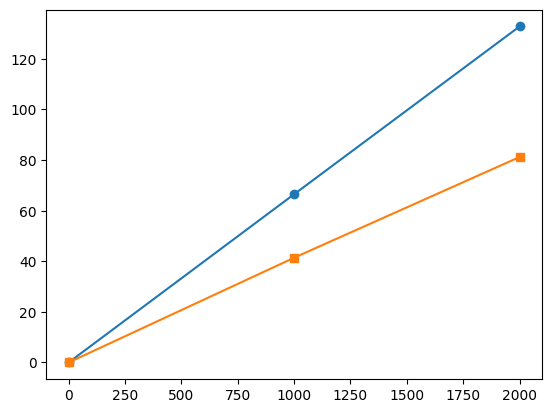

In [67]:
# Create datasets and dataloaders
train_dataset = FrequencyCombDataset(fb_peaks, train_nsamples, bounds)
test_dataset = FrequencyCombDataset(fb_peaks, test_nsamples, bounds)

In [68]:
train_dataset.data_size()

332.03125

In [101]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False)

# Initialize the model
model = FrequencyCombNet().to(device)
model_name = "model_test5000_64"

# load model
if os.path.isfile('saved_models/'+ model_name +'.pth'):
    model.load_state_dict(torch.load('saved_models/'+ model_name +'.pth'))
    model.eval()

# Função de perda (loss function)
criterion = nn.MSELoss() # Erro quadrático médio (Mean Squared Error)

# Otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # taxa de aprendizado - lr (learning rate)

In [102]:
def plot_training_progress(train_losses):
    epochs = len(train_losses)

    plt.plot(range(1, epochs + 1), train_losses,"-", label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.show()

Epoch [1000/10000], Loss: 0.00047548161819577217


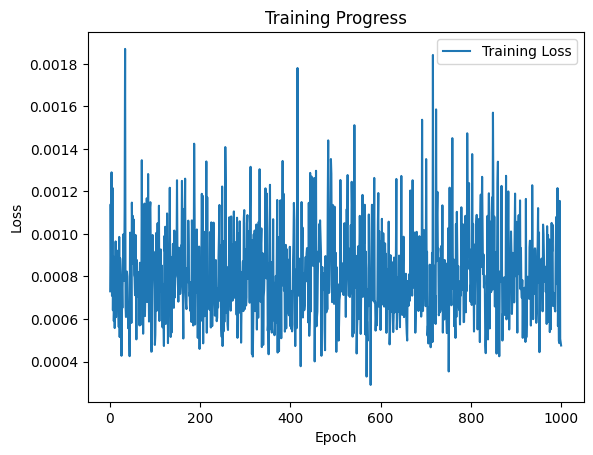

Epoch [2000/10000], Loss: 0.0009591351263225079


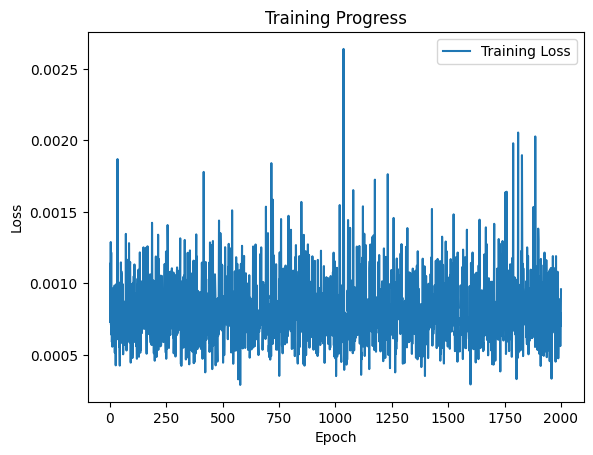

Epoch [3000/10000], Loss: 0.0008272900013253093


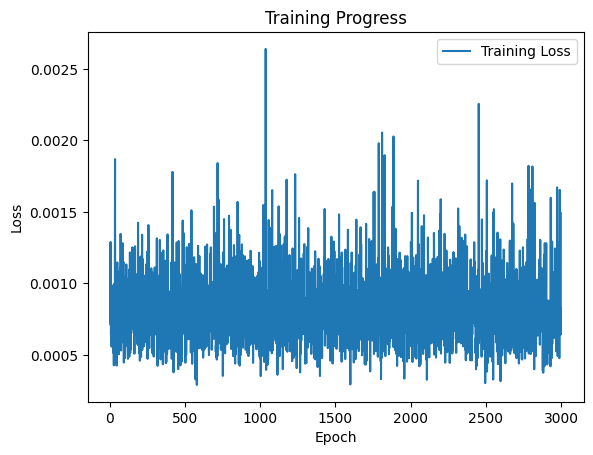

Epoch [4000/10000], Loss: 0.0007322171004489064


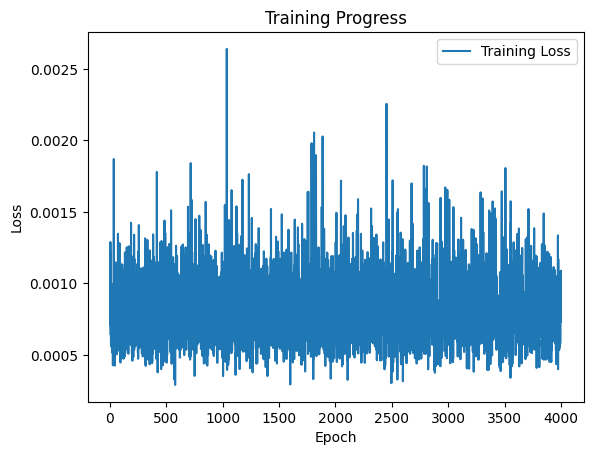

Epoch [5000/10000], Loss: 0.0007299885037355125


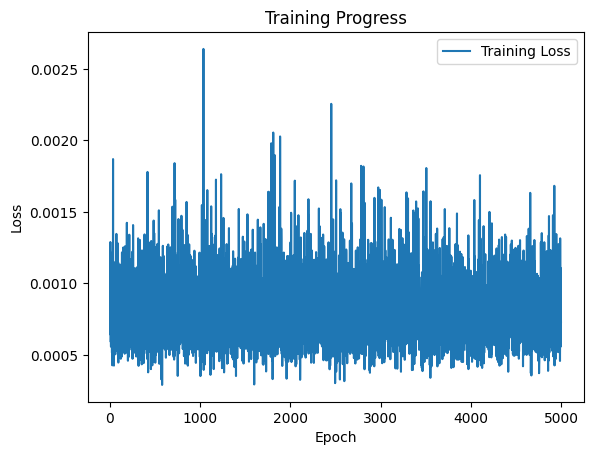

Epoch [6000/10000], Loss: 0.0007014918955974281


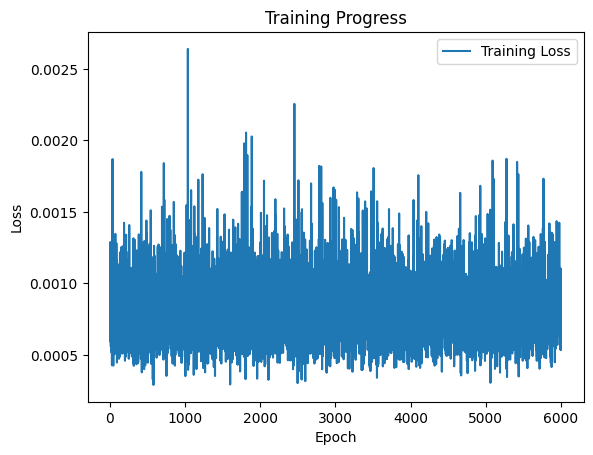

Epoch [7000/10000], Loss: 0.0007575824274681509


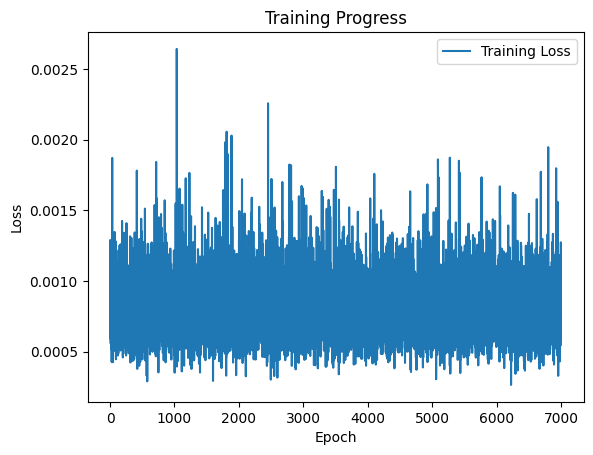

Epoch [8000/10000], Loss: 0.0008531180792488158


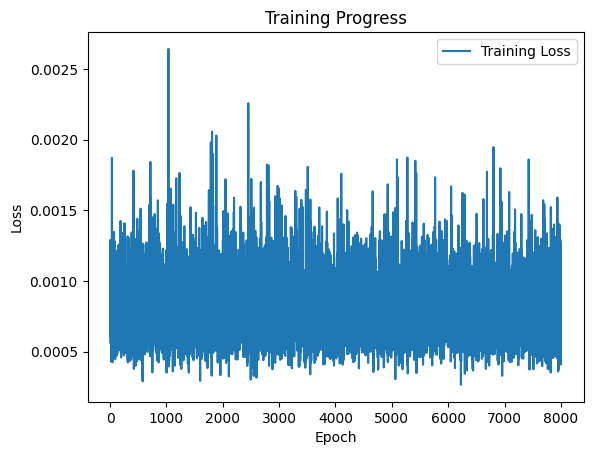

Epoch [9000/10000], Loss: 0.0008722766069695354


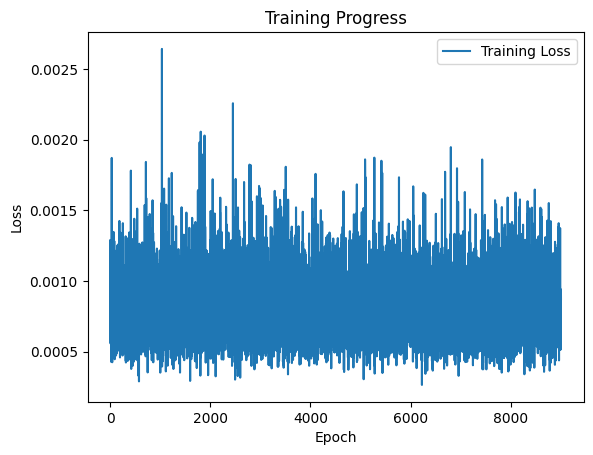

Epoch [10000/10000], Loss: 0.0005337103502824903


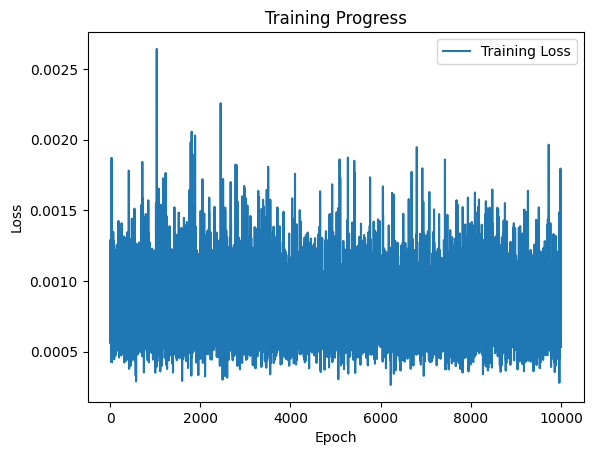

In [140]:
# Training loop
train_losses = []
num_epochs = 10000

for epoch in range(1, num_epochs + 1):
    model.train() # Set model to training mode
    for inputs, targets in train_loader:
        
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs) # Calculate outputs (forward pass)
        loss = criterion(outputs, targets) # Calculate loss

        # Backward pass
        optimizer.zero_grad()  # Reset gradients tensors
        loss.backward() # Calculate gradients
        optimizer.step() # Update weights
    
        # Delete tensors and free up GPU memory
        #del inputs, targets, outputs # Delete tensors
        #torch.cuda.empty_cache() # Clear cache

    # Save training losses for plotting
    train_losses.append(loss.item())

    if(epoch%1000 == 0):
        # Print training progress
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')
        plot_training_progress(train_losses)

torch.save(model.state_dict(), 'saved_models/'+ model_name +'.pth')

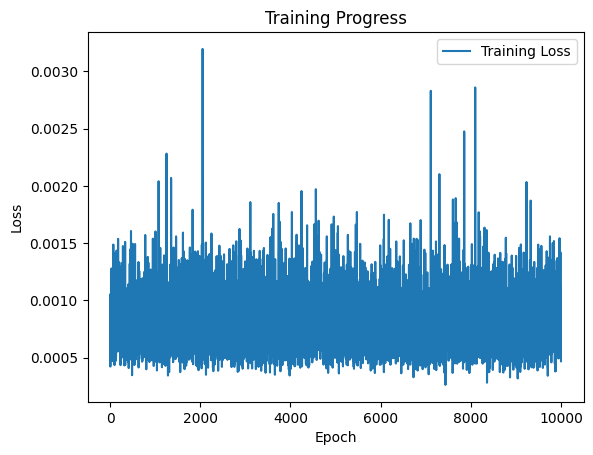

In [135]:
plot_training_progress(train_losses)

In [143]:
# Testing loop
model.eval() # Set model to evaluation mode]
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs) # Forward pass
        test_loss += criterion(outputs, targets).item() # Calculate loss

    # Print test loss
    print(f'Test Mean Loss: {test_loss / len(test_loader)}')

Test Mean Loss: 0.00478320405818522


inputs:  tensor([2.6314, 2.2817, 1.7129, 1.9915, 3.0517, 2.3865, 0.6847, 2.1805],
       device='cuda:0')


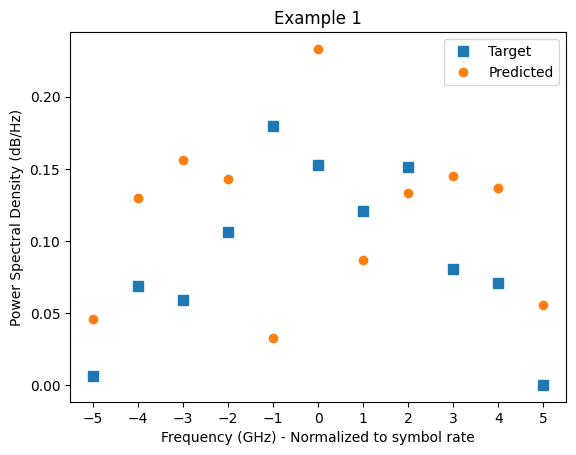

inputs:  tensor([1.4593, 0.3316, 3.9469, 2.5411, 1.5562, 0.8124, 2.8736, 0.4164],
       device='cuda:0')


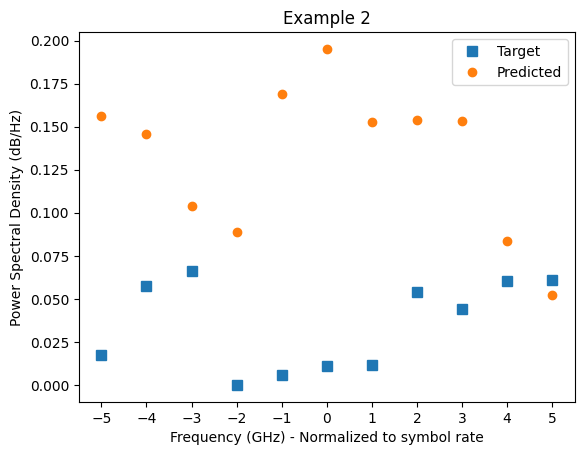

inputs:  tensor([1.9021, 1.6703, 7.0290, 2.7713, 2.6937, 5.3671, 0.5668, 1.6605],
       device='cuda:0')


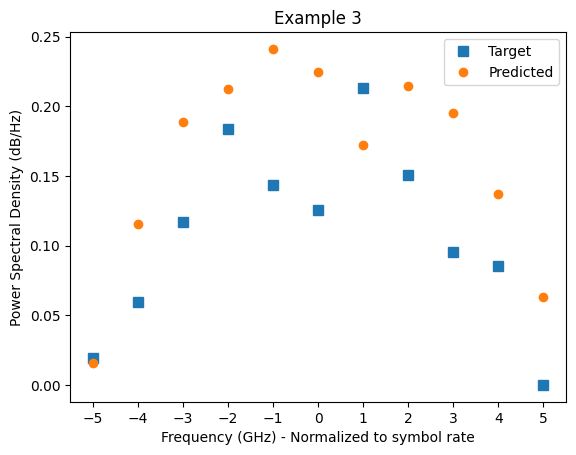

inputs:  tensor([1.4659, 2.5699, 1.1599, 2.5958, 1.4708, 3.6725, 2.2166, 1.1962],
       device='cuda:0')


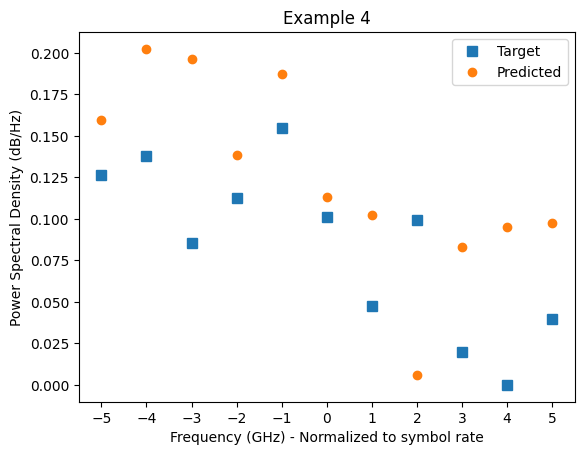

inputs:  tensor([0.5583, 1.1256, 5.0584, 1.9212, 3.0853, 0.4128, 2.6939, 3.0080],
       device='cuda:0')


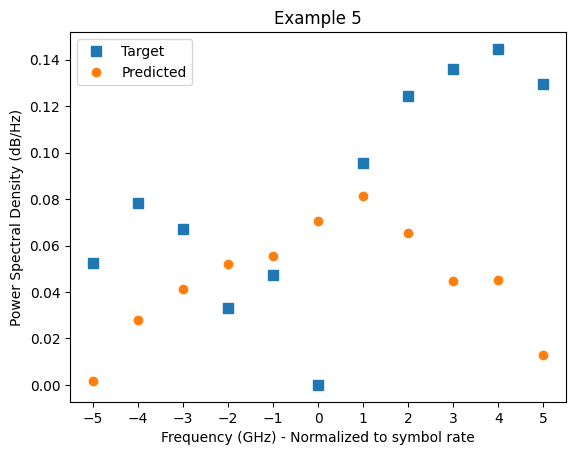

inputs:  tensor([0.1984, 0.0671, 5.3991, 1.9077, 2.7519, 7.2111, 0.6856, 0.2145],
       device='cuda:0')


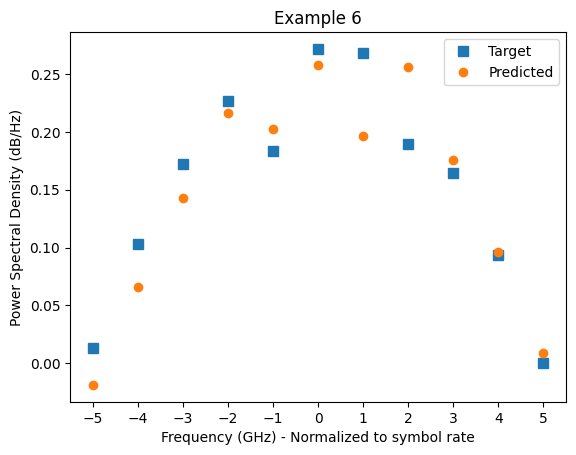

inputs:  tensor([0.4194, 2.8215, 1.5171, 2.3422, 0.5493, 3.8336, 0.1301, 0.8343],
       device='cuda:0')


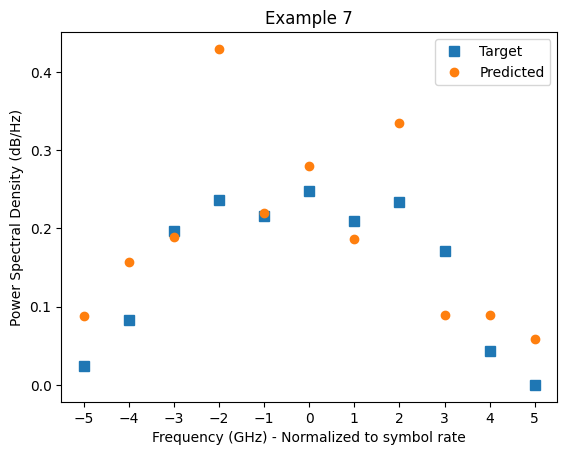

inputs:  tensor([2.2121, 0.6020, 7.9404, 1.4538, 1.8808, 6.8122, 1.6402, 2.2590],
       device='cuda:0')


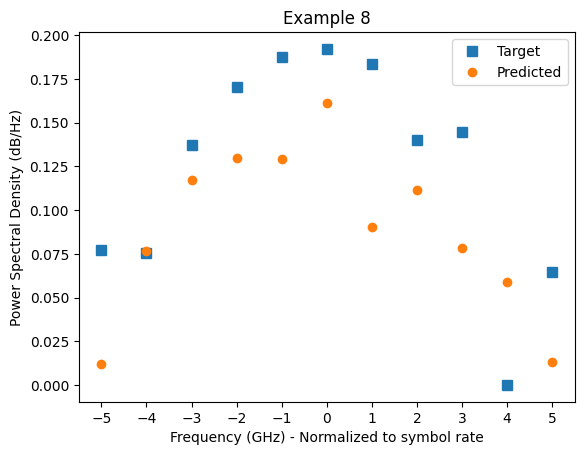

inputs:  tensor([1.7070, 2.4964, 7.3813, 1.0942, 2.6134, 5.3818, 0.1303, 1.3519],
       device='cuda:0')


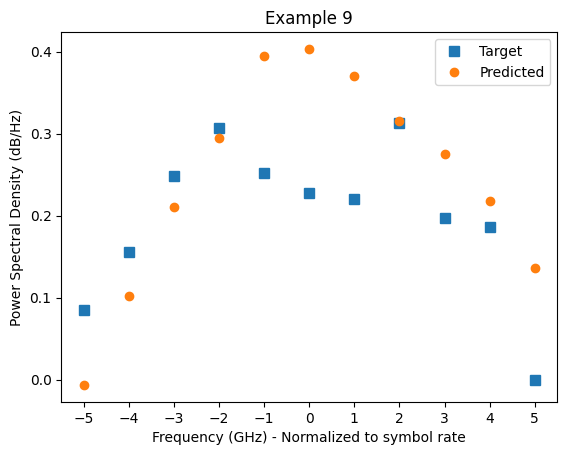

inputs:  tensor([1.7728, 3.0069, 0.1429, 1.5244, 1.2304, 2.7191, 0.7594, 0.5072],
       device='cuda:0')


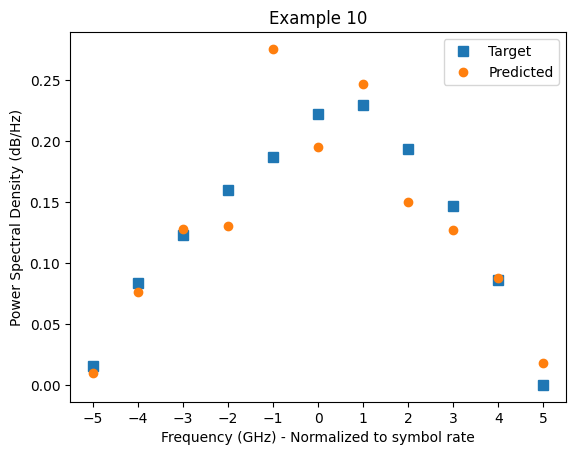

In [144]:
for i in range(min(10, inputs.shape[0])):  # Loop over the first n examples
    plt.figure()
    print("inputs: ", inputs[i])
    plt.plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),targets[i].cpu().numpy(),"s", label='Target',markersize=7)
    plt.plot(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks),outputs[i].cpu().numpy(),"o", label='Predicted')
    plt.xticks(np.linspace(-(n_peaks//2),n_peaks//2,n_peaks))
    plt.xlabel("Frequency (GHz) - Normalized to symbol rate")
    plt.ylabel("Power Spectral Density (dB/Hz)")
    plt.legend()
    plt.title(f'Example {i+1}')
    plt.show()